<a href="https://colab.research.google.com/github/acastellanos-ie/NLP-MBDS-EN/blob/main/06_transfer_learning_and_fine_tuning/practice_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Colab Configuration

**Execute this steps to configure the Google Colab environment in order to execute this notebook. It is not required if you are executing it locally and you have properly configured your local environment according to what explained in the Github Repository.**

In [7]:
# @title Colab Setup

repository_name = "NLP-MBDS-EN"
repository_url = 'https://github.com/acastellanos-ie/' + repository_name

print("### Cloning the Repository ###")
! git clone $repository_url
print()

print("### Installing requirements ###")
! pip3 install -Uqqr $repository_name/06_transfer_learning_and_fine_tuning/requirements.txt

%cd $repository_name/06_transfer_learning_and_fine_tuning

### Cloning the Repository ###
Cloning into 'NLP-MBDS-EN'...
remote: Enumerating objects: 4727, done.
remote: Counting objects: 100% (4727/4727), done.
remote: Compressing objects: 100% (4420/4420), done.
remote: Total 4727 (delta 298), reused 4684 (delta 278), pack-reused 0 (from 0)
Receiving objects: 100% (4727/4727), 18.59 MiB | 13.78 MiB/s, done.
Resolving deltas: 100% (298/298), done.

### Installing requirements ###
/content/NLP-MBDS-EN/text_classification_practice_dl/NLP-MBDS-EN/text_classification_practice_dl/NLP-MBDS-EN/06_transfer_learning_and_fine_tuning


Everything is set up properly! You can now move on to the practice code.

I do recommend you to restart the environment at this point to ensure that Google Colab is aware of the installed packages and their configuration (see image below).

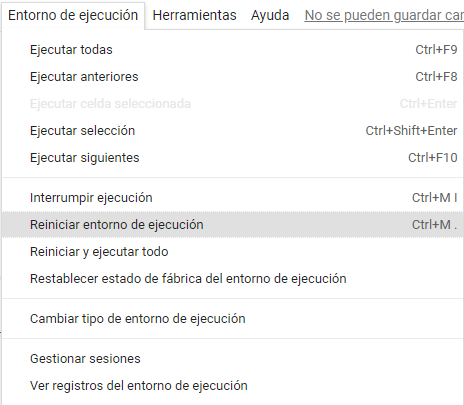

Ensure that you have the GPU runtime activated:

![](https://miro.medium.com/max/3006/1*vOkqNhJNl1204kOhqq59zA.png)

Now you have everything you need to execute the code in Colab

In [5]:
from IPython.core.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

# Matplotlib conf
import matplotlib.pyplot as plt
%matplotlib inline

# Seaborn conf
import seaborn as sns
sns.set_palette(sns.color_palette("seismic"))

import sys

import pandas as pd
import numpy as np
import operator
import string
import nltk

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.naive_bayes import MultinomialNB


# Introduction


In this practice we will address a text classification problem: we will try to predict whether a given tweet is about a real disaster or not. In particular I propose you the scenario presented at the [Real or Not? NLP with Disaster Tweets Kaggle Competition.](https://www.kaggle.com/c/nlp-getting-started/leaderboard).

To that, I am going to follow 2 different approaches:
- Apply traditional text classification methodologies based on "simple" Machine Learning models
- Apply state-of-the-art deep learning models

I have decided to give Deep Learning a try by applying the classification models explained in class.
However, the dataset we have at our disposal includes "only" 65K documents. We all know that to apply Deep Learning you need tons of data and weeks of training, right?

Well, this in not true, or at least, this is not anymore completely true thanks to **Transfer Learning**. If you are training a huge model from scratch, you do need a lot of data and GPU time. Lucklily for us, these huge models are already pre-trained for many languages using large datasets (e.g. Wikipedia). All we have to do is to adapt these models to our particular domain. 65K documents are not enough to learn English, but they are definitely enough to learn the nuances of the dataset.

Cool, now we have a model adapted to the specific language in my dataset but the business case was to create a classifier. Why am I even doing all of this? In the traditional ML methodologies we were feeding our algorithms with a rather simple representation of our textual contents (The TF-IDF vectors). Now, thanks to the fine-tune pre-trained models, I can feed my classifier with a much more detailed and accurate representation of the input textual content. Therefore, it should be easier to the classifier to better categorize the textual content.


Summing up, my strategy will be:

1.   Use a pre-trained English Language Model trained over a large dataset as starting point.
2.   Adapt this language model to our domain. To that end, I will retrain the model to learn the particular aspects of the dataset.
3.   Create a Machine Learning Classifier on top of the dataset language model


**Side note: I have trained this model on Google Colab to be able to use a GPU.For this reason, I did not include anything about the configuration of the GPU or the installation of the required libraries. To execute it I do recommend you to update it to Google Colab**


# STEP 1: Loading and preprocessing the data

Before starting to play with the DeepLearning models we need to read, inspect and clean (if needed) the dataset.

The dataset is provided in 2 different CSV files (one for training and another one for test)

In [8]:
training_df = pd.read_csv('nlp_disaster/data/train.csv', sep=',', index_col=0)
training_df = training_df.sample(frac=1).reset_index(drop=True)
training_df.head()

,keyword,location,text,target
0,derailed,NYC,Sad that biker beatdown derailed his pro-democ...,1
1,curfew,turner fenton,ball has no curfew https://t.co/SG1FTKaEgq,0
2,hostages,TonyJ@Centralizedhockey.com,Holmgren: We referred to those 35 days as 'the...,1
3,demolition,US-PR,@Treyarch @DavidVonderhaar bring back demolit...,0
4,devastation,"Washington, DC",70 Years After Atomic Bombs Japan Still Strugg...,1


As you can see, the training set contains the dependent variable (1 or 0, real or not) as well as some independent variables: the actual text of the tweet and some of the metadata related

In [9]:
test_df = pd.read_csv('nlp_disaster/data/test.csv', sep=',', index_col=0)
test_df.head()

,keyword,location,text
id,,,
0,NaN,NaN,Just happened a terrible car crash
2,NaN,NaN,"Heard about #earthquake is different cities, s..."
3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


The test set contains the same independent variables, but no label whatsoever. This is the common scenario proposed by Kaggle. You get a training set to create your models and then you have to use these models to predict over the test set.

## Inspecting the data

In this step I will try to make sense of the kind of data that we have.

### Class distribution

The first thing I will do is to inspect the distribution of the target variable to check if we have an imbalace problem

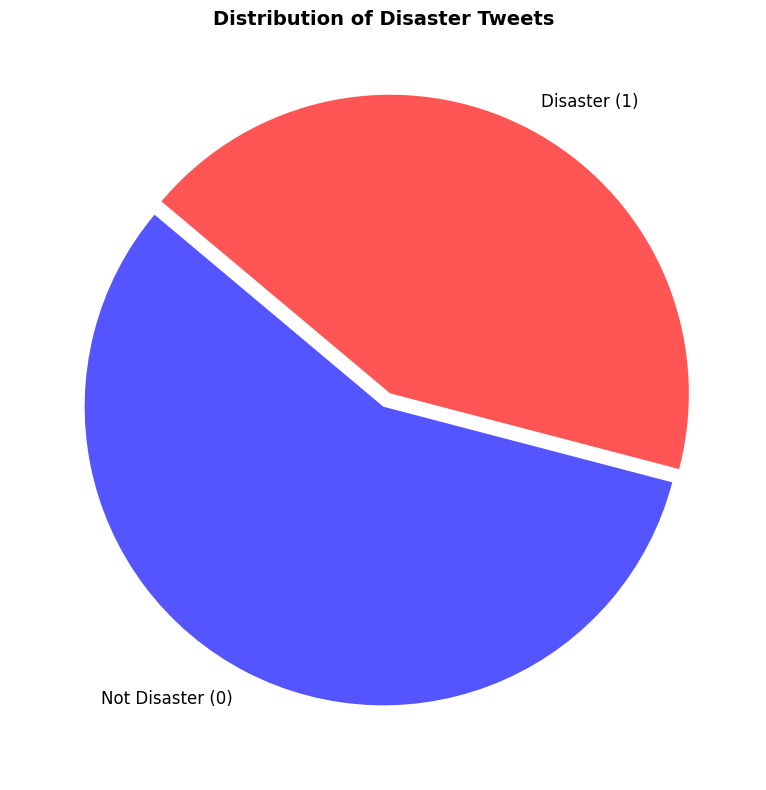

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data calculation
target_counts = training_df['target'].value_counts()
labels = ['Not Disaster (0)', 'Disaster (1)']
colors = sns.color_palette("seismic", n_colors=2)

# Create figure with only the Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(target_counts, labels=labels, startangle=140,
        colors=colors, explode=(0, 0.05), textprops={'fontsize': 12})

plt.title('Distribution of Disaster Tweets', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

As seen in the figure, There are a slight difference between the number of tweets at each class but nothing to worry about.

### Metadata

Beyond the textual content, we have 2 pieces of information:

 - keyword: the keyword used as query to retrieve the tweets
 - location: Location of the user posting the tweet

Regarding the **keywords**, some of them can be strongly related to a given category, but they can be also highly ambiguous as you can see in the following figure (I used the code in this kernel to create it: https://www.kaggle.com/grantgasser/eda-naive-bayes-bert-glove-fasttext-nn).


In [ ]:
# Copy the dataframes to be able to come back to the original version
df_train = training_df.copy()
df_test = test_df.copy()

df_train['target_mean'] = df_train.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=df_train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=df_train.sort_values(by='target_mean', ascending=False)['target'], palette='seismic')

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

df_train.drop(columns=['target_mean'], inplace=True)

Given that the keywords are already included in the textual content (the tweets have been retrieved because they include some of the keywords), I have decided to discard this information as I expect that we can learn the importance of the keywords as individual tokens in the textual content.

A future work that I recommend you to consider is to create a classifier just based on the keywords and compare its performance to the most advanced ones that I am proposing in this solution. If a Classifier simply based on the keywords is good enough, perhaps you can stick to it, thus avoiding the complexities of dealing with textual information.

Let's analyze the **location**.

The first aspect to consider is that it has many null values

In [ ]:
print("% of null columns =", (len(training_df.location) - training_df.location.count())/len(training_df))

This is a common features of any twitter dataset. For privacy reasons, many people prefer to keep their locations to themselves. This could change in the case of a disaster, you may want to share your location to give a better understanding of the disaster. I am not going to focus on this idea and, again, I encourage you to test it and check if you can further improve your models.

Summing up, I will only focus on the textual information (`text` column) of the dataset.

### Textual Data

At this point we have to options:

- Focus just on the actual textual content by applying the NLP methodologies addressed in class for text classification
- Increase the information in the dataset by feature-engineer some new features derived from the textual content (e.g., lenght of the tweets, how many stopwords in the tweets, how many urls...).
    
To further analyze if this idea makes sense, I have used the code in this kernel (https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert) to create some of these features and plot them against the target variable

In [ ]:
nltk.download('stopwords')

# word_count
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
df_test['word_count'] = df_test['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
df_train['unique_word_count'] = df_train['text'].apply(lambda x: len(set(str(x).split())))
df_test['unique_word_count'] = df_test['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
df_train['stop_word_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in nltk.corpus.stopwords.words("english")]))
df_test['stop_word_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in nltk.corpus.stopwords.words("english")]))

# url_count
df_train['url_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
df_test['url_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
df_train['mean_word_length'] = df_train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
df_test['mean_word_length'] = df_test['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
df_test['char_count'] = df_test['text'].apply(lambda x: len(str(x)))

# punctuation_count
df_train['punctuation_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
df_test['punctuation_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
df_train['hashtag_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
df_test['hashtag_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
df_train['mention_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
df_test['mention_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

In [ ]:
import warnings
warnings.filterwarnings('ignore')

METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']
DISASTER_TWEETS = df_train['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(df_train.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green')
    sns.distplot(df_train.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red')

    sns.distplot(df_train[feature], label='Training', ax=axes[i][1], color='green')
    sns.distplot(df_test[feature], label='Test', ax=axes[i][1], color='red')

    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()

    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

These figures shows the comparison between the class `disaster` and `not disaster` in the training set (on the left) and the comparison between the training and test datasets (on the right) for the different derived features.

In general terms, they do not provide any interesting insight. The distribution of all of these new features are basically the same in both classes and datasets. Consequently, I do not expect them to be of any help for creating the classification models (or at least I do not expect their impact to be large enough to motivate their use). At a closer inspection, the length of the tweets seems to be slightly different between the classes. In this sense, you can test this aspect by including these new feature in your models and check if you can improve your final model.

Anyhow, I have decided to just use the textual information without any new feature to create my models

### Text Processing and Data Preparation

Let's try a basic Natural Language Pre-processing:

 - Extract English Words
 - Stem words to avoid over counting same meaning words
 - Removing stop words


I will join training and test datasets to apply the same process to both

In [ ]:
dataset = pd.concat([training_df,test_df], sort=True)

To encapsulate this process and facilitate its application, we create a function `process_text` which encloses all the text processing

In [ ]:
from nltk.stem import *
from nltk.corpus import stopwords

import re

def process_text(raw_text):

    letters_only = re.sub("[^a-zA-Z]", " ",raw_text)
    words = letters_only.lower().split()

    stops = set(stopwords.words("english"))
    not_stop_words = [w for w in words if not w in stops]

    stemmer = PorterStemmer()
    stemmed = [stemmer.stem(word) for word in not_stop_words]

    return( " ".join( stemmed ))

We now apply this function to the textual content.
Just in case we need the raw text later, we will create new columns to store the processed text.

In [ ]:
dataset['clean_text'] = dataset['text'].apply(lambda x: process_text(x))
dataset.head()

We now split the dataset again for the creation and evaluation of the models into training and test


In [ ]:
X_train = dataset[0:len(training_df)][["clean_text"]]
y_train = dataset[0:len(training_df)][["target"]]
X_test = dataset[len(training_df):len(dataset)][["clean_text"]]
y_test = dataset[len(training_df):len(dataset)][["target"]]

# STEP 2: Machine Learning Models

Now that we have a clean version of the dataset we can move to the training of ML models.

Before starting the training process, we need to take care of some aspects related to the data format

Labels are in string format. It is preferred to have them numerically encoded. To that end, sklearn provides a `LabelEncoder` to facilitate this encoding

In [ ]:
# Hot encoding for the labels
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y_train.target.values)
target_labels = le.classes_
encoded_y_train = le.transform(y_train.target.values)


We then need to convert the textual content into numerical feature vectors (i.e., Vector Space Model), applying the bags of words representation:

 - Assign an id to each word of the training set.
 - For each document `d`, count the number of occurrences of each word `w` and store it in `X[i, j]` as the value of feature `j` where `j` is the index of `w` in the dictionary

Sklearn has also some useful functions for this textual processing that we will make use of.

We are going to use the `CountVectorizer` for creating the feature vectors and the `TfidfTransformer` which returns the Document-Term Matrix with the terms weighted by means of their TF-IDF score.

In [ ]:
count_vect = CountVectorizer(analyzer = "word")
train_features = count_vect.fit_transform(X_train['clean_text'])
test_features = count_vect.transform(X_test['clean_text'])

tfidf = TfidfTransformer(norm="l2")
train_text_tfidf_features = tfidf.fit_transform(train_features)
test_text_tfidf_features = tfidf.fit_transform(test_features)

Now we have our dataset in the needed format that will allow us to create our baseline models

To train, evaluate and compare the models I've created a function `train_and_evaluate_classifier` that takes the training data, a classifier definition and a grid to optimize the classifier to train a predictive model.

In [ ]:
def train_and_evaluate_classifier(X, yt, estimator, grid):
    """Train and Evaluate a estimator (defined as input parameter) on the given labeled data using accuracy."""

    # Cross validation
    from sklearn.model_selection import ShuffleSplit
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

    from sklearn.model_selection import GridSearchCV
    grid_search = GridSearchCV(estimator=estimator, cv=cv,  param_grid=grid, error_score=0.0, n_jobs = -1, verbose = 0)

    # Train the model over and tune the parameters
    print("Training model")
    grid_search.fit(X, yt)

    # CV-score
    print("Best score: %0.3f" % grid_search.best_score_)
    if len(grid) > 0:
        print("Best parameters set:")
        best_parameters = grid_search.best_estimator_.get_params()

    return grid_search

## Approach #1: Naïve Bayes

Let's apply Naïve Bayes for the textual classification.
Remember for class that in order to predict the class of a given document we compute the "Maximum Apriori Probability":

\begin{equation*}
MAP   = max({P(c_1|w_1,...w_n), P(c_2|w_1,...,w_n)})
\end{equation*}

To compute $P(c|w_1,...w_n)$, we will use the Bayes theorem:

\begin{equation*}
P(c|w_1,...w_n) = \frac{P(w_1,...,w_n|c)P(c)}{P(w_1,...,w_n)}
\end{equation*}

Being "naive", we can assume that w_1, ..., w_n are independent among them. Therefore:

\begin{equation*}
P(w_1,...,w_n|c) = P(w_1|c)P(w_2|c) ... P(w_n|c)
\end{equation*}

We use the column `clean_text` to create the features through the count vectorizer object

In [ ]:
nb_text_cls = train_and_evaluate_classifier(train_text_tfidf_features, encoded_y_train, MultinomialNB(), {})

80% of Accuracy is a strong baseline. In this solution I am going to explore more solutions to further enhance these results. Nevertheless, if you are trying to create a production system, it could be enough. As you could have seen, it is quite easy and fast to train a NB classifier.

Only if you actually need a state of the art classifier you could delve into the following methodologies.

## Approach 2: SVM

As seen in class, SVM is better suited for text classification, providing a more accurate model. By making use of sklearn, we are going to implement a SVM classifier and then apply it to detect fake news and check if we can improve our baseline Naïve Bayes model.


We now make use of the `train_and_evaluate_classifier` function

In [ ]:
# SVM model
from sklearn.svm import SVC

svm_grid = [
  {'C': [0.01, 0.1, 1], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': ['scale', 'auto'], 'kernel': ['rbf']},
 ]

svm_cls = train_and_evaluate_classifier(train_text_tfidf_features, encoded_y_train, SVC(), svm_grid)

As expected, better than our baseline model based on NB.

In general, SVM is a more suited algorithm for text classification than Naive Bayes. It's up to you to decided if the increase in complexity is justified by the increase in performance

## Approach 3: MaxEnt Classifiers

In class we studied the maxent classifiers. They are probabilistic models especially suited for text classification since they do not assume any independence between the textual contents.
They are expected to offer better results than simple NB without the complexity of SVM. Let's try it.

In [ ]:
from sklearn.linear_model import LogisticRegression
max_ent_grid= {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}
max_ent_cls = train_and_evaluate_classifier(train_text_tfidf_features, encoded_y_train, LogisticRegression(), max_ent_grid)

Results are close to those offered by NB.

Usually this is not the case: MaxEnt usually works way better for text classification than NB. However, we have to consider again the special scenario in which we are: Twitter.

In Twitter, the textual content is very scarce (we have only a bunch of words). In this scenario, even simple approaches like NB are able to capture the overall meaning of a textual content. If you think about it, in order to understand if some tweet is about an actual disaster, many times is just enough to detect a couple of highly words (fire, California), instead of having to deeply understande the textual content of the tweets. In this sense, the independence assumption in which NB relies is not so wrong anymore, thus offering a similar result than more "intelligent" approaches.

Summing up, with traditional ML we have been able to achieve a performance around 80%. That's not bad, however I would like to give a try to some of the most advanced classification methodologies, based on Deep Learning.

As you will see, thanks to some libraries it is not so difficult/scary as it might seem.

# STEP 3: Transformers. Is attention all you need for Text Classification?

Here I want to go a step beyond to apply the most advanced methodologies in the NLP state-of-the-art: Transformers. We have already discussed Transformers in class, as well as their advantages over other methodologies.
Using Transformes might sound scary (many hyperparameters, you have to deal with tensor, shapes, transform your data....). However, there are a number of libraries and wrappers that will make your life easier (or at least less miserable). In particular, in this solution I will make use of two of

 - [HuggingFace](https://huggingface.co/): They provide under the [`transformers`](https://github.com/huggingface/transformers) library a large number of pre-trained state-of-the-art pretrained NLP models together with some handy functions to load them, fine-tune them and put them into practice.

Let the fun begin!


## Prepare the data

This is a preliminary step that we need in order to prepare the data in the right format to be ingested by the transformer model.

Traditional Machine Learning models require manual "feature engineering". Transformers are different: they use a Tokenizer to convert raw text into a mathematical representation that preserves the context and relationship between words. Before training, we must convert our Pandas DataFrames into a "Hugging Face Dataset" format, which is optimized for memory and speed when working with large language models.

In [ ]:
from datasets import Dataset, DatasetDict

# We convert our dataframes into Hugging Face Dataset objects
train_ds = Dataset.from_pandas(training_df)
test_ds = Dataset.from_pandas(test_df)

# Note: We rename 'target' to 'label' because the Trainer API
# looks for a column named 'label' by default to calculate loss.
train_ds = train_ds.rename_column("target", "label")

train_val_split = train_ds.train_test_split(test_size=0.2, seed=42)

# We create a DatasetDict to keep everything organized in one object
# Create the final DatasetDict structure
dataset = DatasetDict({
    'train': train_val_split['train'],
    'validation': train_val_split['test'], # renamed to validation for clarity
    'test': Dataset.from_pandas(test_df)   # The unlabeled data from your CSV
})

print("Dataset prepared for tokenization.")
print(dataset)

## Tokenization

As already explained in class, Tokenization is one of the key steps before using any Deep Learning Model.

Computers cannot "read" words. Tokenization breaks down sentences into smaller units (tokens) and map them to unique integers. We must use the specific tokenizer that was used when that model was originally trained. We also apply padding (to make all tweets the same length) and truncation (to cut off tweets that are too long) so the data can be processed in parallel batches.

In [ ]:
from transformers import AutoTokenizer

# Load the tokenizer associated with DistilBERT
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def preprocess_function(examples):
    # This function processes the 'text' column from our CSV
    return tokenizer(examples["text"], truncation=True, padding=True)

# Apply the tokenizer to the entire dataset
tokenized_dataset = dataset.map(preprocess_function, batched=True)

## Create & Fine-Tune the Transformer Model

We will start again with a Language Model pre-trained using a huge dataset: a model that speaks English. The model in particular is the well-know BERT. We already explained the basic rationale of BERT in class, but just as a reminder: it applies the idea of Self-Attention (instead of an RNN architecture) to learn the sequential information of textual contents. If you want to know more, let me refer you again to this great blog post: http://jalammar.github.io/illustrated-bert/.

We have to also fine-tune this model: Retrain the model to our specific dataset and task. In more detail, the BERT model provides a encoder block with pre-trained weights which gives BERT a general understanding of English. The BERT encoder block will look at each input tweet as a whole, producing an output that contains an understanding of the textual content of the tweet. This representation is then feed to a Text classifier.

Since our dataset is not very large, you can fine-tune the model in a reasonable amount of time if you have a GPU at your disposal (if you don't just use Google Colab or another platform offering GPUs as I did. Do not try to train this model in your laptop if you do not want to potentially wait for hours).

I also recommend you to take a look to DistilBERT. DistillBERT is a “distilled” (a.k.a. reduced) version of BERT that is smaller and faster while retaining most of BERT’s accuracy. Check this blog post from HuggingFace for more details on DistillBERT and the whole idea of Knowledge Distillation: https://medium.com/huggingface/distilbert-8cf3380435b5).

There are many other pre-trained models that HuggingFace provides. You can check the entire Model zoo in the following link: https://huggingface.co/transformers/pretrained_models.html.

The first thing to do is to select the optimal learning rate.

The Learning Rate (LR) is the most important hyperparameter in Deep Learning. It controls how much we adjust the model's "knowledge" in response to the errors it makes.
- If the LR is too high, the model will over-correct and fail to learn (it "explodes").
- If the LR is too low, the model will take too long to learn or get stuck in a "local minimum."

For fine-tuning pre-trained Transformers, we use very small rates (like $2 \times 10^{-5}$) because the model already knows English; we are just teaching it the specific nuance of "disaster tweets."


In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
import evaluate

# Load accuracy metric
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# Initialize the model with 2 output labels (Disaster vs Not Disaster)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

# Define the training strategy
training_args = TrainingArguments(
    output_dir="./disaster_model",
    learning_rate=2e-5,          # This is our chosen Learning Rate
    per_device_train_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",  # Changed from evaluation_strategy to eval_strategy
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_steps=50
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

# STEP 4: Evaluate and Inspect the Model

Now that the model is trained, we use it for Inference. This is the "production" phase where we give the model brand-new tweets (from your test_df) that it has never seen before. The model will output a probability for each class, and we take the highest one as the final prediction. This allows us to see how well our model generalizes to the real world.



In [ ]:
from transformers import pipeline

# We use the 'pipeline' API for easy inference
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Predict on the first 5 tweets of the test set
sample_test_tweets = test_df['text'].tolist()[:5]
predictions = classifier(sample_test_tweets)

for tweet, pred in zip(sample_test_tweets, predictions):
    # Mapping 'LABEL_1' back to 'Disaster' for readability
    label = "DISASTER" if pred['label'] == 'LABEL_1' else "NOT RELEVANT"
    print(f"Tweet: {tweet[:60]}...")
    print(f"Prediction: {label} (Confidence: {pred['score']:.2f})\n")

Large Deep Learning models are well-know for being quite black-boxy. However, in this section, I would like to provide you with some tools to evaluate and analyze them.

First I will create the confussion matrix to understand the performance of the model and to check the accuracy and F-measure.


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# 1. Get predictions from the trainer on the validation set
predictions = trainer.predict(tokenized_dataset["validation"])
preds = np.argmax(predictions.predictions, axis=-1)
labels = predictions.label_ids

# 2. Generate and Plot the Confusion Matrix
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Regular Tweet', 'Disaster Tweet'])

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title("Confusion Matrix: Disaster vs. Regular Tweets")
plt.show()

# 3. Print F-measure and detailed report
print(classification_report(labels, preds, target_names=['Regular Tweet', 'Disaster Tweet']))

The model is a little bit better on detecting regular tweets; I guess that this is because we have more of those. Anyhow, it works pretty well for both classes in terms of accuracy and F-measure.


If you want to better understand how the model is working, you can examine the validation tweets about which the model was the most wrong about (i.e., the top losses).

In [ ]:
import torch.nn.functional as F
import torch
import pandas as pd

# 1. Calculate loss for each individual sample in validation
model.eval()
validation_dataloader = trainer.get_test_dataloader(tokenized_dataset["validation"])
all_losses = []

with torch.no_grad():
    for batch in validation_dataloader:
        inputs = {k: v.to(model.device) for k, v in batch.items() if k in ['input_ids', 'attention_mask', 'labels']}
        outputs = model(**inputs)
        # Use cross entropy with reduction=None to get loss per sample
        loss = F.cross_entropy(outputs.logits, inputs['labels'], reduction='none')
        all_losses.extend(loss.cpu().numpy())

# 2. Map losses back to original tweets for inspection
val_df = pd.DataFrame({
    'text': dataset['validation']['text'],
    'true_label': labels,
    'pred_label': preds,
    'loss': all_losses
})

# 3. Show the top 5 most "wrong" tweets
top_losses = val_df.sort_values(by="loss", ascending=False).head(5)
print("--- Top 5 Errors (Highest Loss) ---")
for i, row in top_losses.iterrows():
    print(f"Loss: {row['loss']:.4f} | True: {row['true_label']} | Pred: {row['pred_label']}")
    print(f"Tweet: {row['text']}\n")

# Step 5: Introduction to Zero-Shot Classification

In this exercise, we delve into the realm of zero-shot text classification using a pre-trained language model. Zero-shot classification refers to the model's ability to accurately categorize text into specific classes without having been explicitly trained on those classes.

## Exercise Overview:

- **Objective**: To classify texts from our dataset as either related to an actual disaster or not, using a zero-shot approach.
- **Model Utilized**: We are employing a model from the Hugging Face library, pre-trained on diverse datasets, enabling it to understand and infer the context and categorize texts appropriately.
- **Method**: The model receives texts and candidate labels ("Disaster" and "Not a Disaster") and predicts the relevance of each label to the text.
- **Evaluation**: We'll assess the model's performance against our dataset's actual labels, using metrics such as accuracy and F1 score to gauge its effectiveness.

This exercise offers a practical application of zero-shot classification, showcasing how advanced NLP models can be leveraged for complex categorization tasks without the need for extensive task-specific training.




The following cell illustrates the application of zero-shot classification using the `transformers` library, specifically leveraging the `facebook/bart-large-mnli` model. This model is an instance of BART (Bidirectional and Auto-Regressive Transformers) adapted for the MultiNLI (Multi-Genre Natural Language Inference) task. It excels in tasks requiring nuanced understanding of context and inference, making it ideal for zero-shot classification where the model must categorize texts into classes not seen during training.

## Applying the Model:
- **Pipeline Initialization**: We initialize the zero-shot classification pipeline with the BART model fine-tuned on the MNLI dataset. The pipeline is a high-level abstraction that wraps around the model and tokenizer, simplifying the task of text classification. It automatically handles the preprocessing of text and post-processing of model predictions
- **Classification Task**: Our task is to classify texts as "Disaster" or "Not a Disaster". To that end, we just need to define what `labels` we want the model to use. This showcases the model's ability to apply learned inferences to new, unseen categories.

Explore the model further on the [Hugging Face Model Hub](https://huggingface.co/facebook/bart-large-mnli).

In [ ]:
from transformers import pipeline

# Load the zero-shot classification pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Example text (replace this with the text from your dataset)
text = "Two cranes restoring a bridge in the central Dutch city of Alphen aan den Rijn collapsed on houses."

# Candidate labels for classifying whether the text is about an actual disaster
labels = ["Disaster", "Not a Disaster"]

# Perform classification
result = classifier(text, labels)

print(f"Text: {text}")
print(f"Labels: {result['labels']}")
print(f"Scores: {result['scores']}")


Now we will apply the previous pipeline to classify the data in our test dataset. As this is a rather slow process, I will subsample 1% of the data and apply it only to that. Feel free to extend it to the entire dataset.

To simplify the application of the zero-shot-classification pipeline, I have created a wrapper function `classify_text`.

In [ ]:
import pandas as pd
from transformers import pipeline
from tqdm.auto import tqdm

# Assuming training_df is your DataFrame and it has a column named 'text'

# Load the zero-shot classification pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Function to classify a single piece of text
def classify_text(text):
    labels = ["Disaster", "Not a Disaster"]
    result = classifier(text, labels)
    return result['labels'][0]

# Wrap your pandas apply with tqdm for a progress bar
tqdm.pandas(desc="Classifying")

sample_df = training_df.sample(frac=0.01)

# Apply the classifier to each row in the DataFrame
sample_df['predicted_label'] = sample_df['text'].progress_apply(classify_text)

# Display the first few rows of the DataFrame to verify
sample_df.head()


Finally, we would like to evaluate the peformance of our model.

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd

# Map your actual labels to the same format as your predicted labels, if necessary
# For example, if your actual labels are 0 and 1, map them to ['Not a Disaster', 'Disaster']
label_mapping = {0: 'Not a Disaster', 1: 'Disaster'}
sample_df['actual_label'] = sample_df['target'].map(label_mapping)

# Calculate Accuracy
accuracy = accuracy_score(sample_df['actual_label'], sample_df['predicted_label'])
print(f"Accuracy: {accuracy:.4f}")

# Calculate Precision, Recall, and F1 Score
precision, recall, f1, _ = precision_recall_fscore_support(sample_df['actual_label'], sample_df['predicted_label'], average='binary', pos_label='Disaster')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


As you can see, results are far from those achieved by previous methods. The main reasons are:


*   The model that we are using is far from being the state of the art. In that sense, I recommend you to try more advanced models (e.g., LLaMA-2 or ChatGPT)
*   We have not tried any prompt engineering technique. By refining the prompt, we will be able to explain the model exactly what we expect from it
*   We can extend to few-shot learning, meaning we can provide the model with some annotated examples (e.g, tweets classified as Disaster or Not Disaster) to learn from











As an example, in this cell we will make use of an advanced LLM out of OpenAI's interface. The process is similar, but connecting to the OpenAI API via LangChain.

Be aware, that in order to execute it, you need an OpenAI API KEY and pay for it ;)




In [ ]:
# 1) install and import
!pip install --quiet openai langchain

import os
from langchain import PromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.chains import LLMChain

# 2) Configure your OpenAI key
os.environ["OPENAI_API_KEY"] = "YOUR_API_KEY"

# 3) Define your labels and example
labels = ["Disaster", "Not Disaster"]
example_text = "A sudden earthquake struck the city at dawn, collapsing buildings."

# 4) Build the prompt
template = """
Classify the following text into one of these labels: {labels}

Text:
{text}

Answer with exactly one label."""
prompt = PromptTemplate(input_variables=["text","labels"], template=template)

# 5) Create and run the chain
llm = ChatOpenAI(model="gpt-4o-mini",temperature=0)
chain = LLMChain(llm=llm, prompt=prompt)
result = chain.run(text=example_text, labels=", ".join(labels))

# 6) Display the result
print("Input:     ", example_text)
print("Prediction:", result.strip())